All of the imports are here

In [4]:
import os
import skimage.io as io
import skimage.transform as trans

import tensorflow as tf
from keras.models import *
from keras.layers import *
from keras.losses import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.utils.generic_utils import get_custom_objects 

import rawpy
import cv2
import numpy as np
from numpy import genfromtxt
from sklearn.preprocessing import StandardScaler
import pandas
import matplotlib.pyplot as plt

import hyperas
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

import time

data function is necessary for the hyperoptimization because it provides all the data the model needs which are training and validation.

In [5]:
def data():
    trainPath = "/home/takats_balint1/deephf/data/Sony_train_list.txt"
    replaceString = "/home/takats_balint1/deephf/data"

    trainData = []
    with open(trainPath) as File:
        for line in File:
            data, truth, _, _ = line.split()
            data = data.replace(".", replaceString, 1)
            truth = truth.replace(".", replaceString, 1)
            
            trainData.append([data, truth])
            
    valPath = "/home/takats_balint1/deephf/data/Sony_val_list.txt"

    valData = []
    with open(valPath) as File:
        for line in File:
            data, truth, _, _ = line.split()
            data = data.replace(".", replaceString, 1)
            truth = truth.replace(".", replaceString, 1)
            valData.append([data, truth])
    
    HEIGHT = 64
    WIDTH = 64
    
    # Loading train data from the small dataset (64x64)
    trainPermutation = np.random.permutation(len(trainData))
    data = [None] * len(trainData)
    truth = [None] * len(trainData)
     
    for i in range(0, len(trainPermutation)):
        in_path = trainData[trainPermutation[i]][0]
        truth_path = trainData[trainPermutation[i]][1]
        in_exposure = float(in_path[53:-5])
        gt_exposure = float(truth_path[52:-5])
        ratio = min(gt_exposure / in_exposure, 300)
        truth[i] = ratio
        
        file = trainData[trainPermutation[i]][0]
        good = file.replace("data", "smalldata").replace("ARW", "csv")
        datafile = genfromtxt(good, delimiter=',')
        raw = datafile.reshape((HEIGHT, WIDTH,3))
        
        data[i] = raw
        
    # Loading validation data from the small dataset (64x64)
    valPermutation = np.random.permutation(len(valData))
    val_data = [None] * len(valData)
    val_truth = [None] * len(valData)
    
    for i in range(0, len(valPermutation)):
        in_path = valData[valPermutation[i]][0]
        truth_path = valData[valPermutation[i]][1]
        in_exposure = float(in_path[53:-5])
        gt_exposure = float(truth_path[52:-5])
        ratio = min(gt_exposure / in_exposure, 300)
        val_truth[i] = ratio
        
        file = valData[valPermutation[i]][0]
        good = file.replace("data", "smalldata").replace("ARW", "csv")
        datafile = genfromtxt(good, delimiter=',')
        raw = datafile.reshape((HEIGHT, WIDTH,3))
        
        val_data[i] = raw

    data = np.array(data)
    truth = np.array(truth)
    val_data = np.array(val_data)
    val_truth = np.array(val_truth)
    
    # Normalizing
    truth = truth.reshape(-1, 1)
    val_truth = val_truth.reshape(-1, 1)
    scaler = StandardScaler()
    truth = scaler.fit_transform(truth)
    val_truth = scaler.fit_transform(val_truth)
    
    return data, truth, val_data, val_truth

Here we define our model and choose between the paramertes for it from the given choices. We save the model parameters into a .csv file

In [6]:
def create_model(data, truth, val_data, val_truth):    
            
    # Each parameter is choosing one from their choises every evaluation
    n_layer1 = {{choice([4, 8, 16, 32])}}
    n_layer2 = {{choice([4, 8, 16, 32])}}
    n_layer3 = {{choice([4, 8, 16, 32])}}
   
    dropout_1 = {{uniform(0, 0.5)}}
    dropout_2 = {{uniform(0, 0.5)}}
    
    k_size1 = {{choice([3, 5])}}
    k_size2 = {{choice([3, 5])}}
   
    act = {{choice(['relu', 'leakyrelu', 'elu'])}}
    optim = {{choice(['rmsprop', 'adam', 'sgd'])}}    
    n_batch = {{choice([2, 4, 8, 16, 32])}}
    lr = {{choice([0.00001, 0.0001, 0.001, 0.01])}}
    stride_1 = {{choice([1, 2])}}
    stride_2 = {{choice([1, 2])}}
    stride_3 = {{choice([1, 2])}}
    
    print('Hyperparams: ', n_layer1, n_layer2, n_layer3, dropout_1, dropout_2, k_size1, k_size2, act, optim, n_batch, lr)
    
    HEIGHT = 64
    WIDTH = 64
    
    activat = ReLU()
    if act == 'leakyrelu':
        activat = LeakyReLU()
    elif act == 'elu':
        activat = ELU()
    
    if optim == 'rmsprop':
        optimiz = RMSprop(learning_rate=lr)
    elif optim == 'sgd':
        optimiz = SGD(learning_rate=lr)
    elif optim == 'adam':
        optimiz = Adam(learning_rate=lr)
        
    # Making the model with the choosen parameters
    model = Sequential() 
    model.add(Conv2D(n_layer1, kernel_size=(k_size1, k_size1), activation=activat, input_shape=(HEIGHT, WIDTH, 3), strides= stride_1)) 
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_1))
    model.add(Conv2D(n_layer2, (k_size2, k_size2), activation=activat, strides = stride_2)) 
    model.add(MaxPooling2D(pool_size=(2, 2))) 
    model.add(Dropout(dropout_2))
    model.add(Conv2D(n_layer3, (3, 3), activation=activat, strides = stride_3))
    model.add(Flatten())
    model.add(Dense(1))
    
    model.compile(loss='mse', optimizer=optimiz)   
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=0)]
    
    result = model.fit(data, truth,
              batch_size=n_batch,
              epochs=100,
              verbose=2,
              validation_data=(val_data, val_truth),
              callbacks=callbacks,
              shuffle=True)
    
    # Saving the best validation lost
    best_val_loss = np.amin(result.history['val_loss']) 
    
    print('Best val_loss:', best_val_loss, end='\n\n')
    
    # Log hyperparams
    with open('hyperas-NHF-log.csv', 'a') as csv_file:
      csv_file.write(str(n_layer1) + ';')
      csv_file.write(str(n_layer2) + ';')
      csv_file.write(str(n_layer3) + ';')
      csv_file.write(str(dropout_1) + ';')
      csv_file.write(str(dropout_2) + ';')
      csv_file.write(str(k_size1) + ';')
      csv_file.write(str(k_size2) + ';')
      csv_file.write(str(act) + ';')
      csv_file.write(str(optim) + ';')
      csv_file.write(str(n_batch) + ';')
      csv_file.write(str(lr) + ';')
      csv_file.write(str(stride_1) + ';')
      csv_file.write(str(stride_2) + ';')
      csv_file.write(str(stride_3) + ';')
      csv_file.write(str(best_val_loss) + '\n')

    return {'loss': best_val_loss, 'status': STATUS_OK, 'model': model}

In [7]:
# Log init
with open('hyperas-NHF-log.csv', 'w') as csv_file:
  csv_file.write('n_layer1' + ';')
  csv_file.write('n_layer2' + ';')
  csv_file.write('n_layer3' + ';')
  csv_file.write('dropout_1' + ';')
  csv_file.write('dropout_2' + ';')
  csv_file.write('k_size1' + ';')
  csv_file.write('k_size2' + ';')
  csv_file.write('act' + ';')
  csv_file.write('optim' + ';')
  csv_file.write('n_batch' + ';')
  csv_file.write('lr' + ';')
  csv_file.write('stride_1' + ';')
  csv_file.write('stride_2' + ';')
  csv_file.write('stride_3' + ';')
  csv_file.write('best_val_loss' + '\n')

In [8]:
# Start of the hyperparameter optimalization
start_time = time.time()
best_run, best_model = optim.minimize(model=create_model,
                                          data=data,
                                          algo=tpe.suggest,
                                          max_evals=200,
                                          notebook_name='HyperOptScript',
                                          trials=Trials())
opt_end_time = time.time()

# Printing the time the optimalization took
print("\nHyperOpt time taken: " + str(opt_end_time-start_time))

>>> Imports:
#coding=utf-8

try:
    import os
except:
    pass

try:
    import skimage.io as io
except:
    pass

try:
    import skimage.transform as trans
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    from keras.models import *
except:
    pass

try:
    from keras.layers import *
except:
    pass

try:
    from keras.losses import *
except:
    pass

try:
    from keras.optimizers import *
except:
    pass

try:
    from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
except:
    pass

try:
    from keras.utils.generic_utils import get_custom_objects
except:
    pass

try:
    import rawpy
except:
    pass

try:
    import cv2
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    from numpy import genfromtxt
except:
    pass

try:
    from sklearn.preprocessing import StandardScaler
except:
    pass

try:
    import pandas
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try

Hyperparams:                                           
8                                                      
8                                                      
32                                                     
0.22195220672653282                                    
0.019912544881439953                                   
3                                                      
3                                                      
elu                                                    
sgd                                                    
4                                                      
0.001                                                  
Epoch 1/100                                            
467/467 - 2s - loss: 1.0039 - val_loss: 0.9969         

Epoch 2/100                                            
467/467 - 2s - loss: 1.0003 - val_loss: 0.9965         

Epoch 3/100                                            
467/467 - 2s - loss: 0.9950 - val_loss: 0.9981

sgd                                                                                
4                                                                                  
0.01                                                                               
Epoch 1/100                                                                        
467/467 - 2s - loss: 0.9973 - val_loss: 0.9898                                     

Epoch 2/100                                                                        
467/467 - 2s - loss: 0.9416 - val_loss: 0.9748                                     

Epoch 3/100                                                                        
467/467 - 2s - loss: 0.8991 - val_loss: 0.9828                                     

Epoch 4/100                                                                        
467/467 - 2s - loss: 0.8804 - val_loss: 0.9131                                     

Epoch 5/100                                                             

Epoch 7/100                                                                         
117/117 - 0s - loss: 0.9957 - val_loss: 1.0003                                      

Epoch 8/100                                                                         
117/117 - 0s - loss: 0.9951 - val_loss: 1.0001                                      

Best val_loss:                                                                      
0.9999333024024963                                                                  
Hyperparams:                                                                        
32                                                                                
32                                                                                
32                                                                                
0.032963408821647056                                                              
0.28941514631898013                                                    

117/117 - 1s - loss: 0.6455 - val_loss: 0.7945                                    

Epoch 52/100                                                                      
117/117 - 1s - loss: 0.6377 - val_loss: 0.7884                                    

Epoch 53/100                                                                      
117/117 - 1s - loss: 0.6363 - val_loss: 0.7819                                    

Epoch 54/100                                                                      
117/117 - 1s - loss: 0.6335 - val_loss: 0.7757                                    

Epoch 55/100                                                                      
117/117 - 1s - loss: 0.6309 - val_loss: 0.7713                                    

Epoch 56/100                                                                      
117/117 - 1s - loss: 0.6288 - val_loss: 0.7670                                    

Epoch 57/100                                                                     

0.5852714776992798                                                                
Hyperparams:                                                                      
8                                                                                 
16                                                                                
8                                                                                 
0.0648727283430775                                                                
0.22414604610911326                                                               
3                                                                                 
3                                                                                 
relu                                                                              
rmsprop                                                                           
2                                                                                 
0.01

Best val_loss:                                                                      
0.6694797873497009                                                                  
Hyperparams:                                                                        
4                                                                                   
16                                                                                  
4                                                                                   
0.17626028943442412                                                                 
0.4966950166994325                                                                  
5                                                                                   
5                                                                                   
leakyrelu                                                                           
adam                                                             

5                                                                                   
relu                                                                                
adam                                                                                
32                                                                                  
0.001                                                                               
Epoch 1/100                                                                         
59/59 - 1s - loss: 0.9983 - val_loss: 0.9993                                        

Epoch 2/100                                                                         
59/59 - 0s - loss: 0.9829 - val_loss: 0.9859                                        

Epoch 3/100                                                                         
59/59 - 0s - loss: 0.9177 - val_loss: 1.0389                                        

Epoch 4/100                                                   

Epoch 1/100                                                                       
933/933 - 4s - loss: 1.0000 - val_loss: 1.0005                                    

Epoch 2/100                                                                       
933/933 - 4s - loss: 0.9983 - val_loss: 1.0003                                    

Epoch 3/100                                                                       
933/933 - 4s - loss: 0.9961 - val_loss: 1.0000                                    

Epoch 4/100                                                                       
933/933 - 3s - loss: 0.9933 - val_loss: 0.9997                                    

Epoch 5/100                                                                       
933/933 - 3s - loss: 0.9905 - val_loss: 0.9991                                    

Epoch 6/100                                                                       
933/933 - 3s - loss: 0.9886 - val_loss: 0.9987                                    

59/59 - 0s - loss: 0.9952 - val_loss: 0.9888                                      

Epoch 2/100                                                                       
59/59 - 0s - loss: 0.9495 - val_loss: 0.9953                                      

Epoch 3/100                                                                       
59/59 - 0s - loss: 0.9081 - val_loss: 0.9891                                      

Epoch 4/100                                                                       
59/59 - 0s - loss: 0.8633 - val_loss: 1.0032                                      

Best val_loss:                                                                    
0.988845944404602                                                                 
Hyperparams:                                                                      
32                                                                                
8                                                                                 


sgd                                                                               
32                                                                                
0.0001                                                                            
Epoch 1/100                                                                       
59/59 - 1s - loss: 0.9995 - val_loss: 1.0030                                      

Epoch 2/100                                                                       
59/59 - 1s - loss: 1.0000 - val_loss: 1.0029                                      

Epoch 3/100                                                                       
59/59 - 1s - loss: 0.9998 - val_loss: 1.0029                                      

Epoch 4/100                                                                       
59/59 - 1s - loss: 0.9991 - val_loss: 1.0029                                      

Epoch 5/100                                                                       


117/117 - 0s - loss: 0.9870 - val_loss: 0.9999                                    

Epoch 3/100                                                                       
117/117 - 0s - loss: 0.9784 - val_loss: 1.0112                                    

Epoch 4/100                                                                       
117/117 - 0s - loss: 0.9685 - val_loss: 1.0008                                    

Best val_loss:                                                                    
0.9985129237174988                                                                
Hyperparams:                                                                      
32                                                                                
4                                                                                 
8                                                                                 
0.1272362429561435                                                                
0

59/59 - 0s - loss: 0.8868 - val_loss: 0.9874                                        

Epoch 57/100                                                                        
59/59 - 0s - loss: 0.8827 - val_loss: 0.9871                                        

Epoch 58/100                                                                        
59/59 - 0s - loss: 0.8774 - val_loss: 0.9868                                        

Epoch 59/100                                                                        
59/59 - 0s - loss: 0.8733 - val_loss: 0.9863                                        

Epoch 60/100                                                                        
59/59 - 0s - loss: 0.8728 - val_loss: 0.9861                                        

Epoch 61/100                                                                        
59/59 - 0s - loss: 0.8662 - val_loss: 0.9857                                        

Epoch 62/100                                               

0.001                                                                             
Epoch 1/100                                                                       
59/59 - 0s - loss: 0.9891 - val_loss: 0.9751                                      

Epoch 2/100                                                                       
59/59 - 0s - loss: 0.9487 - val_loss: 0.9434                                      

Epoch 3/100                                                                       
59/59 - 0s - loss: 0.8757 - val_loss: 0.9236                                      

Epoch 4/100                                                                       
59/59 - 0s - loss: 0.8379 - val_loss: 0.9216                                      

Epoch 5/100                                                                       
59/59 - 0s - loss: 0.7945 - val_loss: 0.9127                                      

Epoch 6/100                                                                       

59/59 - 0s - loss: 0.9996 - val_loss: 0.9990                                      

Epoch 45/100                                                                      
59/59 - 0s - loss: 0.9993 - val_loss: 0.9990                                      

Epoch 46/100                                                                      
59/59 - 0s - loss: 1.0002 - val_loss: 0.9990                                      

Epoch 47/100                                                                      
59/59 - 0s - loss: 0.9995 - val_loss: 0.9990                                      

Epoch 48/100                                                                      
59/59 - 0s - loss: 0.9991 - val_loss: 0.9990                                      

Epoch 49/100                                                                      
59/59 - 0s - loss: 0.9995 - val_loss: 0.9990                                      

Epoch 50/100                                                                     

117/117 - 0s - loss: 0.4266 - val_loss: 0.7033                                    

Epoch 15/100                                                                      
117/117 - 0s - loss: 0.4350 - val_loss: 0.6354                                    

Best val_loss:                                                                    
0.6330496668815613                                                                
Hyperparams:                                                                      
8                                                                                 
32                                                                                
4                                                                                 
0.372017369891927                                                                 
0.21437587355518165                                                               
5                                                                                 
3 

467/467 - 2s - loss: 0.9799 - val_loss: 1.0097                                    

Epoch 4/100                                                                       
467/467 - 2s - loss: 0.9688 - val_loss: 1.0196                                    

Epoch 5/100                                                                       
467/467 - 2s - loss: 0.9565 - val_loss: 1.0107                                    

Best val_loss:                                                                    
1.0091968774795532                                                                
Hyperparams:                                                                      
4                                                                                 
8                                                                                 
32                                                                                
0.2025467948613479                                                                
0

234/234 - 1s - loss: 0.5477 - val_loss: 0.7532                                    

Epoch 11/100                                                                      
234/234 - 1s - loss: 0.5642 - val_loss: 0.7380                                    

Best val_loss:                                                                    
0.6719626784324646                                                                
Hyperparams:                                                                      
4                                                                                 
16                                                                                
4                                                                                 
0.25043456823841775                                                               
0.4073134141754249                                                                
5                                                                                 
3 

0.01                                                                              
Epoch 1/100                                                                       
59/59 - 0s - loss: 0.9357 - val_loss: 0.8922                                      

Epoch 2/100                                                                       
59/59 - 0s - loss: 0.7337 - val_loss: 0.7499                                      

Epoch 3/100                                                                       
59/59 - 0s - loss: 0.6491 - val_loss: 0.7422                                      

Epoch 4/100                                                                       
59/59 - 0s - loss: 0.5652 - val_loss: 0.7431                                      

Epoch 5/100                                                                       
59/59 - 0s - loss: 0.5273 - val_loss: 0.6303                                      

Epoch 6/100                                                                       

933/933 - 3s - loss: 0.9336 - val_loss: 0.9847                                    

Epoch 3/100                                                                       
933/933 - 3s - loss: 0.8255 - val_loss: 0.9534                                    

Epoch 4/100                                                                       
933/933 - 3s - loss: 0.7445 - val_loss: 0.8839                                    

Epoch 5/100                                                                       
933/933 - 3s - loss: 0.6769 - val_loss: 0.7965                                    

Epoch 6/100                                                                       
933/933 - 3s - loss: 0.6233 - val_loss: 0.7113                                    

Epoch 7/100                                                                       
933/933 - 3s - loss: 0.5927 - val_loss: 0.6670                                    

Epoch 8/100                                                                      

Epoch 4/100                                                                       
59/59 - 0s - loss: 0.5037 - val_loss: 0.5152                                      

Epoch 5/100                                                                       
59/59 - 0s - loss: 0.4771 - val_loss: 0.5513                                      

Epoch 6/100                                                                       
59/59 - 0s - loss: 0.4532 - val_loss: 0.6885                                      

Epoch 7/100                                                                       
59/59 - 0s - loss: 0.4566 - val_loss: 0.5233                                      

Best val_loss:                                                                    
0.5151801705360413                                                                
Hyperparams:                                                                      
32                                                                                


Epoch 40/100                                                                      
59/59 - 0s - loss: 0.9861 - val_loss: 0.9898                                      

Epoch 41/100                                                                      
59/59 - 0s - loss: 0.9848 - val_loss: 0.9896                                      

Epoch 42/100                                                                      
59/59 - 0s - loss: 0.9850 - val_loss: 0.9893                                      

Epoch 43/100                                                                      
59/59 - 0s - loss: 0.9848 - val_loss: 0.9892                                      

Epoch 44/100                                                                      
59/59 - 0s - loss: 0.9839 - val_loss: 0.9890                                      

Epoch 45/100                                                                      
59/59 - 0s - loss: 0.9836 - val_loss: 0.9887                                      

32                                                                                
0.01                                                                              
Epoch 1/100                                                                       
59/59 - 1s - loss: 0.9234 - val_loss: 0.9475                                      

Epoch 2/100                                                                       
59/59 - 1s - loss: 0.7399 - val_loss: 0.9097                                      

Epoch 3/100                                                                       
59/59 - 1s - loss: 0.5538 - val_loss: 0.7434                                      

Epoch 4/100                                                                       
59/59 - 1s - loss: 0.4576 - val_loss: 0.7579                                      

Epoch 5/100                                                                       
59/59 - 1s - loss: 0.4293 - val_loss: 0.6892                                      


Epoch 2/100                                                                       
467/467 - 2s - loss: 0.6772 - val_loss: 0.7661                                    

Epoch 3/100                                                                       
467/467 - 2s - loss: 0.5757 - val_loss: 0.7071                                    

Epoch 4/100                                                                       
467/467 - 2s - loss: 0.5559 - val_loss: 0.6841                                    

Epoch 5/100                                                                       
467/467 - 2s - loss: 0.5169 - val_loss: 0.6040                                    

Epoch 6/100                                                                       
467/467 - 2s - loss: 0.4940 - val_loss: 0.5856                                    

Epoch 7/100                                                                       
467/467 - 2s - loss: 0.4880 - val_loss: 0.5612                                    

Epoch 4/100                                                                       
467/467 - 2s - loss: 0.5638 - val_loss: 0.7463                                    

Epoch 5/100                                                                       
467/467 - 2s - loss: 0.5447 - val_loss: 0.6076                                    

Epoch 6/100                                                                       
467/467 - 2s - loss: 0.5106 - val_loss: 0.5678                                    

Epoch 7/100                                                                       
467/467 - 2s - loss: 0.5006 - val_loss: 0.5466                                    

Epoch 8/100                                                                       
467/467 - 2s - loss: 0.4691 - val_loss: 0.5678                                    

Epoch 9/100                                                                       
467/467 - 2s - loss: 0.4652 - val_loss: 0.5587                                    

4                                                                                  
8                                                                                  
0.4072099009936858                                                                 
0.14417231601024244                                                                
3                                                                                  
3                                                                                  
relu                                                                               
adam                                                                               
4                                                                                  
0.001                                                                              
Epoch 1/100                                                                        
467/467 - 2s - loss: 0.9299 - val_loss: 0.9453                              

0.41930903691097043                                                                
0.04132586572819949                                                                
3                                                                                  
3                                                                                  
relu                                                                               
rmsprop                                                                            
4                                                                                  
1e-05                                                                              
Epoch 1/100                                                                        
467/467 - 2s - loss: 1.0039 - val_loss: 0.9980                                     

Epoch 2/100                                                                        
467/467 - 2s - loss: 1.0014 - val_loss: 0.9977                             

467/467 - 2s - loss: 0.7684 - val_loss: 0.8478                                     

Epoch 94/100                                                                       
467/467 - 2s - loss: 0.7610 - val_loss: 0.8463                                     

Epoch 95/100                                                                       
467/467 - 2s - loss: 0.7647 - val_loss: 0.8436                                     

Epoch 96/100                                                                       
467/467 - 2s - loss: 0.7638 - val_loss: 0.8416                                     

Epoch 97/100                                                                       
467/467 - 2s - loss: 0.7585 - val_loss: 0.8393                                     

Epoch 98/100                                                                       
467/467 - 2s - loss: 0.7521 - val_loss: 0.8356                                     

Epoch 99/100                                                          

Epoch 1/100                                                                        
467/467 - 2s - loss: 1.0009 - val_loss: 1.0011                                     

Epoch 2/100                                                                        
467/467 - 2s - loss: 1.0010 - val_loss: 1.0010                                     

Epoch 3/100                                                                        
467/467 - 2s - loss: 1.0006 - val_loss: 1.0010                                     

Epoch 4/100                                                                        
467/467 - 2s - loss: 1.0002 - val_loss: 1.0010                                     

Epoch 5/100                                                                        
467/467 - 2s - loss: 1.0003 - val_loss: 1.0011                                     

Epoch 6/100                                                                        
467/467 - 2s - loss: 1.0017 - val_loss: 1.0011                         

Epoch 15/100                                                                       
467/467 - 2s - loss: 0.9515 - val_loss: 0.9940                                     

Epoch 16/100                                                                       
467/467 - 2s - loss: 0.9478 - val_loss: 0.9935                                     

Epoch 17/100                                                                       
467/467 - 2s - loss: 0.9400 - val_loss: 0.9928                                     

Epoch 18/100                                                                       
467/467 - 2s - loss: 0.9323 - val_loss: 0.9920                                     

Epoch 19/100                                                                       
467/467 - 2s - loss: 0.9246 - val_loss: 0.9909                                     

Epoch 20/100                                                                       
467/467 - 2s - loss: 0.9150 - val_loss: 0.9898                         

Epoch 4/100                                                                          
467/467 - 2s - loss: 0.5531 - val_loss: 0.5546                                       

Epoch 5/100                                                                          
467/467 - 2s - loss: 0.5257 - val_loss: 0.5310                                       

Epoch 6/100                                                                          
467/467 - 2s - loss: 0.5097 - val_loss: 0.5387                                       

Epoch 7/100                                                                          
467/467 - 2s - loss: 0.4892 - val_loss: 0.4982                                       

Epoch 8/100                                                                          
467/467 - 2s - loss: 0.4717 - val_loss: 0.7611                                       

Epoch 9/100                                                                          
467/467 - 2s - loss: 0.4475 - val_loss: 0.8114   

Epoch 4/100                                                                          
933/933 - 4s - loss: 0.5381 - val_loss: 0.6620                                       

Epoch 5/100                                                                          
933/933 - 4s - loss: 0.5005 - val_loss: 0.5136                                       

Epoch 6/100                                                                          
933/933 - 4s - loss: 0.4681 - val_loss: 0.7539                                       

Epoch 7/100                                                                          
933/933 - 4s - loss: 0.4536 - val_loss: 0.8166                                       

Epoch 8/100                                                                          
933/933 - 4s - loss: 0.4124 - val_loss: 0.8181                                       

Best val_loss:                                                                       
0.5135586857795715                               

467/467 - 2s - loss: 0.9698 - val_loss: 1.0008                                     

Epoch 15/100                                                                       
467/467 - 2s - loss: 0.9670 - val_loss: 1.0003                                     

Epoch 16/100                                                                       
467/467 - 2s - loss: 0.9643 - val_loss: 0.9998                                     

Epoch 17/100                                                                       
467/467 - 2s - loss: 0.9614 - val_loss: 0.9991                                     

Epoch 18/100                                                                       
467/467 - 2s - loss: 0.9568 - val_loss: 0.9986                                     

Epoch 19/100                                                                       
467/467 - 2s - loss: 0.9534 - val_loss: 0.9980                                     

Epoch 20/100                                                          

467/467 - 2s - loss: 0.9968 - val_loss: 1.0063                                       

Epoch 4/100                                                                          
467/467 - 2s - loss: 0.9955 - val_loss: 1.0066                                       

Epoch 5/100                                                                          
467/467 - 2s - loss: 0.9954 - val_loss: 1.0063                                       

Best val_loss:                                                                       
1.0041065216064453                                                                   
Hyperparams:                                                                         
16                                                                                   
32                                                                                   
8                                                                                    
0.39349993175295                                   

32                                                                                 
8                                                                                  
0.35335454551828865                                                                
0.18744343576647854                                                                
3                                                                                  
3                                                                                  
relu                                                                               
rmsprop                                                                            
4                                                                                  
0.001                                                                              
Epoch 1/100                                                                        
467/467 - 2s - loss: 0.9114 - val_loss: 1.0290                              

Epoch 2/100                                                                        
117/117 - 0s - loss: 0.9885 - val_loss: 0.9899                                     

Epoch 3/100                                                                        
117/117 - 0s - loss: 0.9777 - val_loss: 0.9872                                     

Epoch 4/100                                                                        
117/117 - 0s - loss: 0.9570 - val_loss: 0.9820                                     

Epoch 5/100                                                                        
117/117 - 0s - loss: 0.9283 - val_loss: 0.9757                                     

Epoch 6/100                                                                        
117/117 - 0s - loss: 0.8992 - val_loss: 0.9683                                     

Epoch 7/100                                                                        
117/117 - 0s - loss: 0.8723 - val_loss: 0.9633                         

0.44930419840976443                                                                
0.14239904350550725                                                                
3                                                                                  
3                                                                                  
elu                                                                                
adam                                                                               
8                                                                                  
0.001                                                                              
Epoch 1/100                                                                        
234/234 - 1s - loss: 0.8575 - val_loss: 0.9800                                     

Epoch 2/100                                                                        
234/234 - 1s - loss: 0.6810 - val_loss: 0.8556                             

Best val_loss:                                                                     
0.5754057168960571                                                                 
Hyperparams:                                                                       
16                                                                                 
4                                                                                  
16                                                                                 
0.4174862506248286                                                                 
0.1253442790226222                                                                 
5                                                                                  
3                                                                                  
relu                                                                               
adam                                                                        

Epoch 4/100                                                                        
467/467 - 2s - loss: 0.5415 - val_loss: 0.5993                                     

Epoch 5/100                                                                        
467/467 - 2s - loss: 0.5122 - val_loss: 0.5595                                     

Epoch 6/100                                                                        
467/467 - 2s - loss: 0.4847 - val_loss: 0.5346                                     

Epoch 7/100                                                                        
467/467 - 2s - loss: 0.4566 - val_loss: 0.4360                                     

Epoch 8/100                                                                        
467/467 - 2s - loss: 0.4436 - val_loss: 0.6248                                     

Epoch 9/100                                                                        
467/467 - 2s - loss: 0.4406 - val_loss: 0.4296                         

Epoch 11/100                                                                         
467/467 - 2s - loss: 0.4173 - val_loss: 0.4653                                       

Epoch 12/100                                                                         
467/467 - 2s - loss: 0.4205 - val_loss: 0.5885                                       

Epoch 13/100                                                                         
467/467 - 2s - loss: 0.4063 - val_loss: 0.5178                                       

Epoch 14/100                                                                         
467/467 - 2s - loss: 0.3923 - val_loss: 0.5851                                       

Best val_loss:                                                                       
0.4652820825576782                                                                   
Hyperparams:                                                                         
8                                                 

Epoch 5/100                                                                          
933/933 - 4s - loss: 0.5388 - val_loss: 0.7381                                       

Epoch 6/100                                                                          
933/933 - 4s - loss: 0.5175 - val_loss: 0.6683                                       

Epoch 7/100                                                                          
933/933 - 4s - loss: 0.5028 - val_loss: 0.6786                                       

Epoch 8/100                                                                          
933/933 - 4s - loss: 0.4754 - val_loss: 0.7241                                       

Epoch 9/100                                                                          
933/933 - 4s - loss: 0.4845 - val_loss: 0.6043                                       

Epoch 10/100                                                                         
933/933 - 4s - loss: 0.4672 - val_loss: 0.6006   

Epoch 30/100                                                                         
467/467 - 2s - loss: 0.8592 - val_loss: 0.9263                                       

Epoch 31/100                                                                         
467/467 - 2s - loss: 0.8533 - val_loss: 0.9227                                       

Epoch 32/100                                                                         
467/467 - 2s - loss: 0.8542 - val_loss: 0.9203                                       

Epoch 33/100                                                                         
467/467 - 2s - loss: 0.8446 - val_loss: 0.9176                                       

Epoch 34/100                                                                         
467/467 - 2s - loss: 0.8439 - val_loss: 0.9158                                       

Epoch 35/100                                                                         
467/467 - 2s - loss: 0.8391 - val_loss: 0.9141   

elu                                                                                  
adam                                                                                 
4                                                                                    
0.001                                                                                
Epoch 1/100                                                                          
467/467 - 2s - loss: 0.8424 - val_loss: 0.8582                                       

Epoch 2/100                                                                          
467/467 - 2s - loss: 0.6563 - val_loss: 0.7168                                       

Epoch 3/100                                                                          
467/467 - 2s - loss: 0.6059 - val_loss: 0.7922                                       

Epoch 4/100                                                                          
467/467 - 2s - loss: 0.5790 - val_loss: 0.7361     

Best val_loss:                                                                       
1.0007174015045166                                                                   
Hyperparams:                                                                         
8                                                                                    
16                                                                                   
32                                                                                   
0.3476590055307659                                                                   
0.25850089853981806                                                                  
5                                                                                    
3                                                                                    
elu                                                                                  
adam                                                  

Epoch 12/100                                                                         
467/467 - 2s - loss: 0.9598 - val_loss: 1.0017                                       

Epoch 13/100                                                                         
467/467 - 2s - loss: 0.9539 - val_loss: 1.0015                                       

Epoch 14/100                                                                         
467/467 - 2s - loss: 0.9506 - val_loss: 1.0012                                       

Epoch 15/100                                                                         
467/467 - 2s - loss: 0.9459 - val_loss: 1.0012                                       

Epoch 16/100                                                                         
467/467 - 2s - loss: 0.9424 - val_loss: 1.0008                                       

Epoch 17/100                                                                         
467/467 - 2s - loss: 0.9354 - val_loss: 1.0003   

relu                                                                                 
rmsprop                                                                              
16                                                                                   
0.001                                                                                
Epoch 1/100                                                                          
117/117 - 1s - loss: 0.9201 - val_loss: 0.9209                                       

Epoch 2/100                                                                          
117/117 - 1s - loss: 0.7261 - val_loss: 0.7638                                       

Epoch 3/100                                                                          
117/117 - 1s - loss: 0.6118 - val_loss: 0.6756                                       

Epoch 4/100                                                                          
117/117 - 1s - loss: 0.5712 - val_loss: 0.6770     

Epoch 11/100                                                                         
467/467 - 2s - loss: 0.5346 - val_loss: 0.7674                                       

Best val_loss:                                                                       
0.7188163995742798                                                                   
Hyperparams:                                                                         
8                                                                                    
32                                                                                   
32                                                                                   
0.42929788796713386                                                                  
0.024382850334023973                                                                 
5                                                                                    
3                                                    

Epoch 87/100                                                                         
933/933 - 4s - loss: 0.5565 - val_loss: 0.7431                                       

Epoch 88/100                                                                         
933/933 - 4s - loss: 0.5596 - val_loss: 0.7367                                       

Epoch 89/100                                                                         
933/933 - 4s - loss: 0.5611 - val_loss: 0.7370                                       

Epoch 90/100                                                                         
933/933 - 4s - loss: 0.5563 - val_loss: 0.7421                                       

Epoch 91/100                                                                         
933/933 - 4s - loss: 0.5491 - val_loss: 0.7337                                       

Epoch 92/100                                                                         
933/933 - 4s - loss: 0.5521 - val_loss: 0.7287   

Epoch 15/100                                                                         
467/467 - 2s - loss: 0.4906 - val_loss: 0.5235                                       

Epoch 16/100                                                                         
467/467 - 2s - loss: 0.4771 - val_loss: 0.4870                                       

Epoch 17/100                                                                         
467/467 - 2s - loss: 0.4759 - val_loss: 0.5769                                       

Epoch 18/100                                                                         
467/467 - 2s - loss: 0.4562 - val_loss: 0.4723                                       

Epoch 19/100                                                                         
467/467 - 2s - loss: 0.4657 - val_loss: 0.4505                                       

Epoch 20/100                                                                         
467/467 - 2s - loss: 0.4339 - val_loss: 0.4280   

Best val_loss:                                                                       
0.9985993504524231                                                                   
Hyperparams:                                                                         
8                                                                                    
4                                                                                    
32                                                                                   
0.21634446573435115                                                                  
0.23080927352385316                                                                  
5                                                                                    
3                                                                                    
relu                                                                                 
adam                                                  

Epoch 1/100                                                                          
467/467 - 2s - loss: 0.9968 - val_loss: 0.9941                                       

Epoch 2/100                                                                          
467/467 - 2s - loss: 0.9872 - val_loss: 0.9902                                       

Epoch 3/100                                                                          
467/467 - 2s - loss: 0.9627 - val_loss: 0.9850                                       

Epoch 4/100                                                                          
467/467 - 2s - loss: 0.9017 - val_loss: 0.9772                                       

Epoch 5/100                                                                          
467/467 - 2s - loss: 0.8506 - val_loss: 0.9636                                       

Epoch 6/100                                                                          
467/467 - 2s - loss: 0.7908 - val_loss: 0.9285   

Reading the logged list of paramertes. We are using the pandas package because it can display our parameters nicely in rows and cloumns.

In [10]:
hyperas_log = pandas.read_csv('hyperas-NHF-log.csv', delimiter=';')

In [11]:
# Best 10 optimization
hyperas_best10 = hyperas_log.sort_values(by=['best_val_loss'], ascending=True).head(n=10)
hyperas_best10

,n_layer1,n_layer2,n_layer3,dropout_1,dropout_2,k_size1,k_size2,act,optim,n_batch,lr,stride_1,stride_2,stride_3,best_val_loss
199,8,4,32,0.406023,0.185245,5,3,relu,adam,2,0.001,2,2,2,0.348148
156,8,32,32,0.499297,0.171813,5,3,relu,rmsprop,4,0.001,2,2,2,0.371201
92,32,4,32,0.382662,0.169203,5,3,relu,adam,4,0.001,2,2,2,0.392773
187,8,4,32,0.479236,0.216422,5,3,relu,adam,4,0.001,2,2,2,0.419040
94,32,4,32,0.451533,0.098284,5,3,relu,adam,4,0.001,2,2,2,0.421105
149,8,32,32,0.431410,0.090334,5,3,relu,rmsprop,4,0.001,2,2,2,0.429572
146,8,32,32,0.497399,0.169026,5,3,relu,rmsprop,4,0.001,2,2,2,0.431612
121,16,32,8,0.375208,0.066674,3,3,relu,rmsprop,4,0.001,2,2,2,0.432450
107,8,32,32,0.476255,0.167912,5,3,relu,rmsprop,4,0.001,2,2,2,0.446890
87,32,8,32,0.384760,0.141723,5,3,relu,adam,32,0.001,2,2,2,0.449496


In [12]:
# Worst 10 optimization
hyperas_worst10 = hyperas_log.sort_values(by=['best_val_loss'], ascending=False).head(n=10)
hyperas_worst10

,n_layer1,n_layer2,n_layer3,dropout_1,dropout_2,k_size1,k_size2,act,optim,n_batch,lr,stride_1,stride_2,stride_3,best_val_loss
49,32,8,32,0.007397,0.156798,5,3,elu,adam,2,0.01000,2,1,2,1.382580
32,4,8,4,0.346284,0.301510,5,3,leakyrelu,adam,32,0.00010,2,2,2,1.009407
62,8,4,4,0.078595,0.356188,5,3,elu,sgd,4,0.00100,1,1,1,1.009197
57,8,32,4,0.372017,0.214376,5,3,elu,sgd,32,0.00010,2,1,2,1.009115
125,16,4,8,0.369528,0.030914,3,3,elu,sgd,16,0.00100,2,2,2,1.007131
127,16,4,8,0.288157,0.084586,3,3,relu,sgd,4,0.00100,2,2,2,1.004107
12,16,32,32,0.142754,0.268561,3,5,leakyrelu,sgd,32,0.00010,2,2,2,1.003571
91,32,8,32,0.499035,0.135896,5,3,relu,adam,32,0.00010,2,2,2,1.002836
39,32,8,32,0.464692,0.124430,5,3,leakyrelu,sgd,32,0.00010,1,1,2,1.002812
64,16,8,4,0.048335,0.252084,3,3,leakyrelu,rmsprop,16,0.00001,2,1,1,1.001407


The diagrams show for each parameter its distribution between the choises. The highlighted ones are the best (red) or the worst (yellow). 

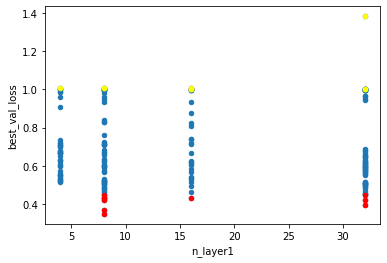

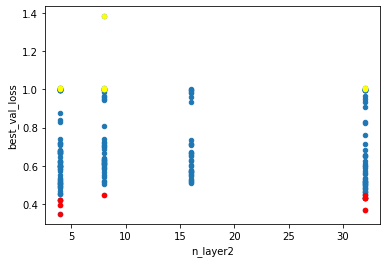

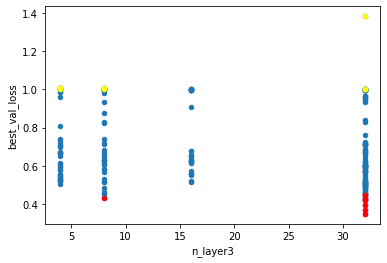

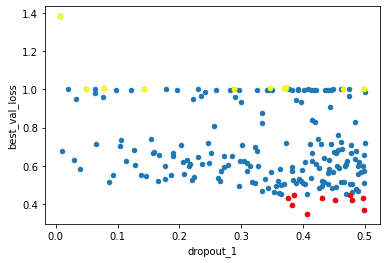

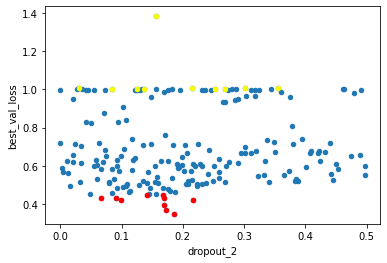

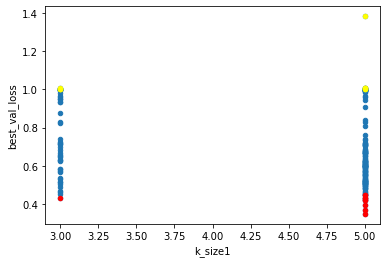

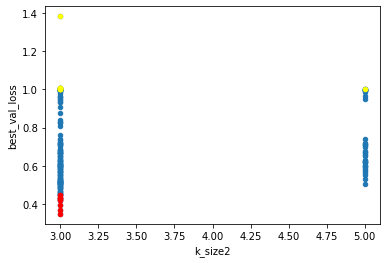

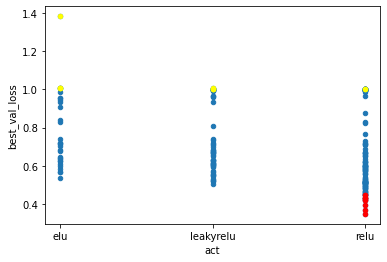

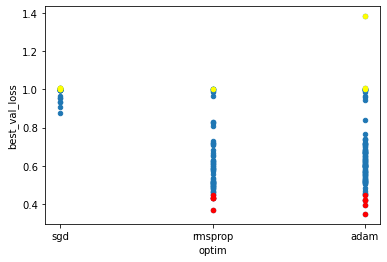

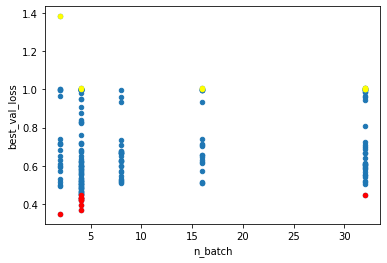

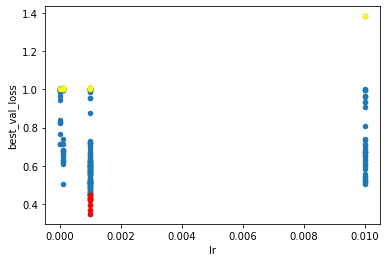

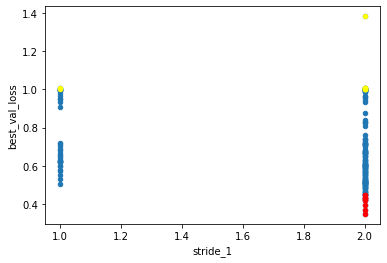

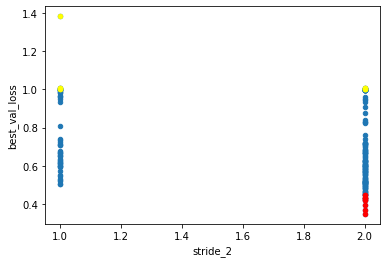

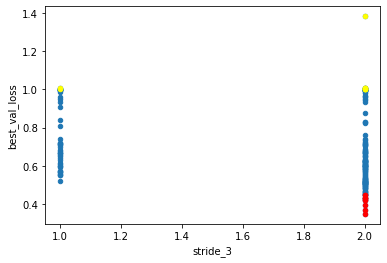

In [13]:
for hyperparam in ['n_layer1', 'n_layer2', 'n_layer3', 'dropout_1', 'dropout_2', 'k_size1', 'k_size2', 'act', 'optim', 'n_batch', 'lr', 'stride_1', 'stride_2', 'stride_3']:
  ax1 = hyperas_log.plot(kind='scatter', x=hyperparam, y='best_val_loss')
  hyperas_best10.plot(kind='scatter', x=hyperparam, y='best_val_loss', color='red', ax=ax1)
  hyperas_worst10.plot(kind='scatter', x=hyperparam, y='best_val_loss', color='yellow', ax=ax1)